# In this notebook we can see that splitting our data geographically for the risk level prediction is not a good approach

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

from sklearn import set_config
set_config(transform_output="pandas")

In [2]:
df = pd.read_csv("flood_tool/resources/postcodes_labelled.csv")

In [3]:
df.head()

,postcode,easting,northing,soilType,elevation,localAuthority,riskLabel,medianPrice,historicallyFlooded
0,OL9 7NS,390978,403269,Unsurveyed/Urban,130,Oldham,1,119100.0,False
1,WV13 2LR,396607,298083,Unsurveyed/Urban,130,Walsall,1,84200.0,False
2,LS12 1LZ,427859,432937,Unsurveyed/Urban,60,Leeds,1,134900.0,False
3,SK15 1TS,395560,397900,Unsurveyed/Urban,120,Tameside,1,170200.0,False
4,TS17 9NN,445771,515362,Unsurveyed/Urban,20,Stockton-on-Tees,1,190600.0,False


# Drop duplicates

In [4]:
df.duplicated().sum()

0

# Train/Test split

In [5]:
sorted_values = df.sort_values(by=['easting','northing'], ascending = True)

In [6]:
test_frac = int(sorted_values.shape[0]*.2)
test_frac

6000

In [7]:
X = sorted_values.drop(columns = 'riskLabel')

In [8]:
y = sorted_values.riskLabel

In [9]:
X_test = X.iloc[:test_frac]
X_train = X.iloc[test_frac:]
y_train = y.iloc[test_frac:]
y_test = y.iloc[:test_frac]

In [10]:
X_test.shape[0]/df.shape[0]

0.2

In [11]:
X_train.shape[0]/df.shape[0]

0.8

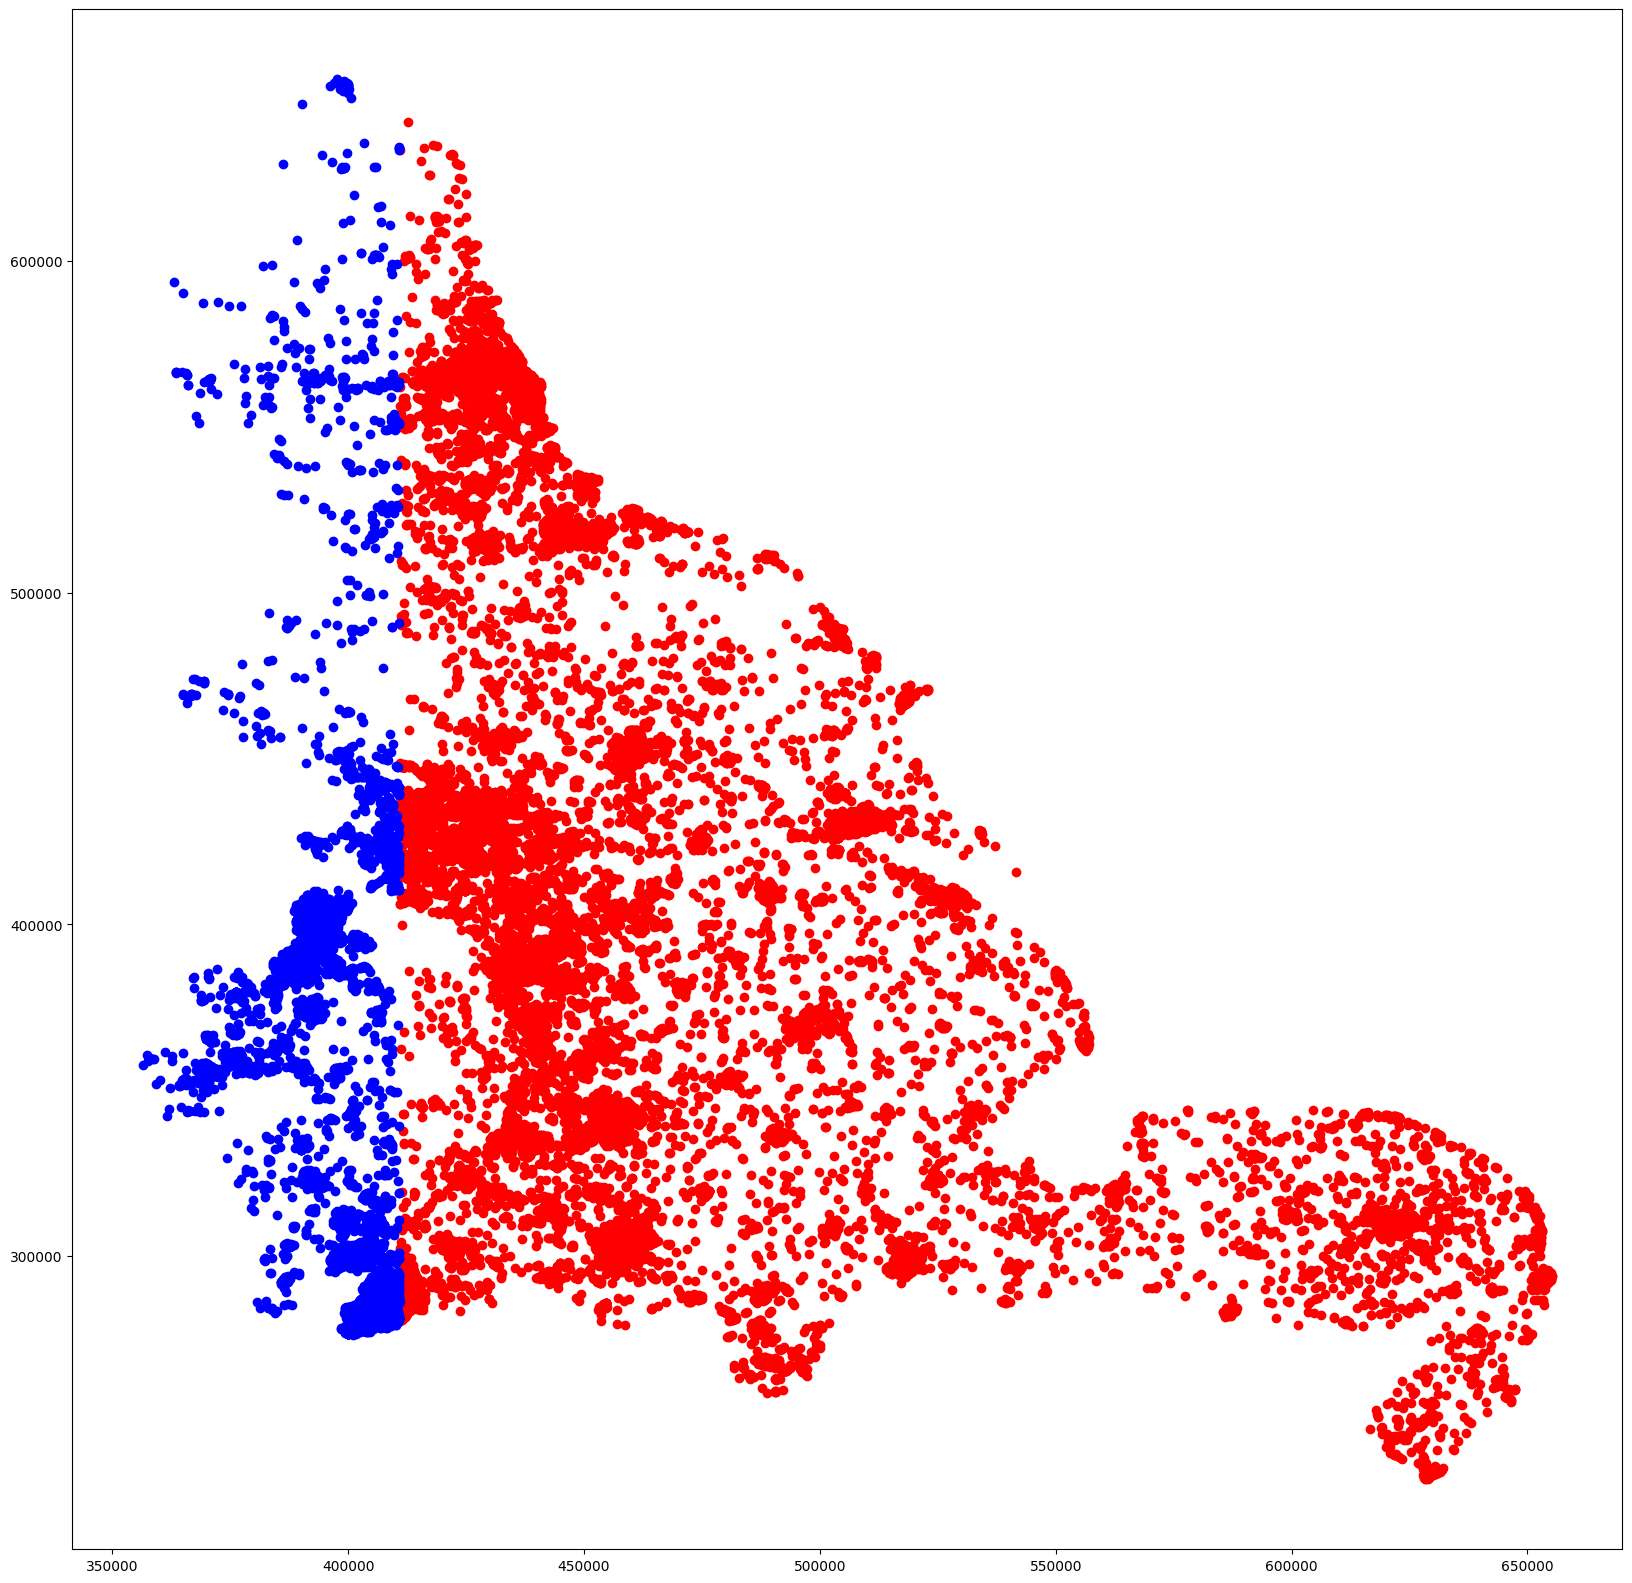

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1, figsize=(20,20))

ax.scatter(X_train.easting, X_train.northing, c='r', label='X_train');
ax.scatter(X_test.easting, X_test.northing, c='b', label='X_test');

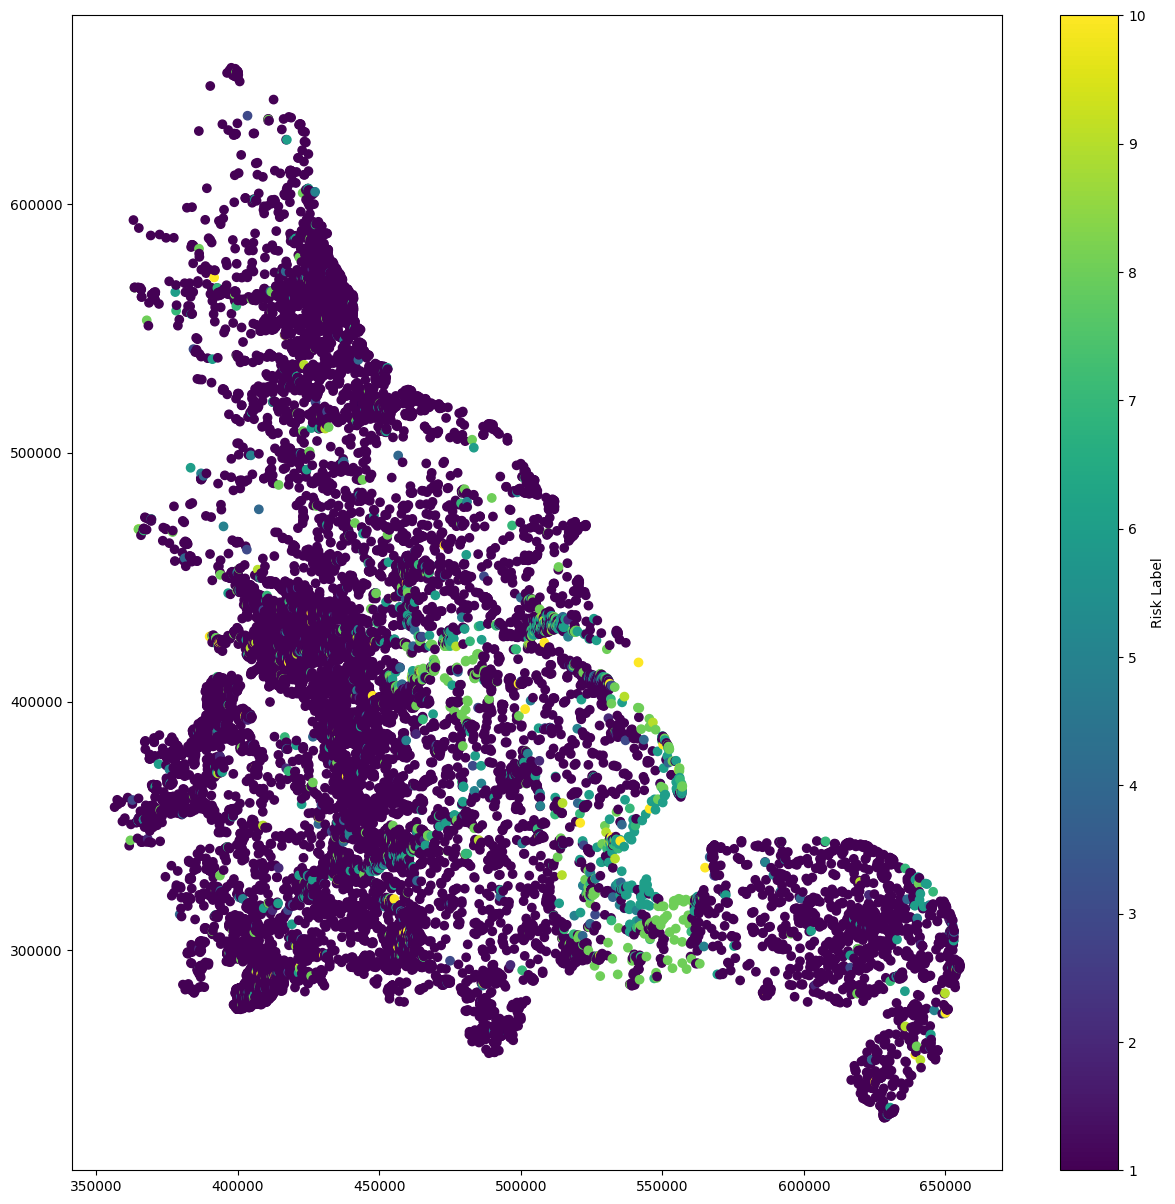

In [13]:
plt.figure(figsize=(15,15))
plt.scatter(sorted_values['easting'], sorted_values['northing'], 
            c=sorted_values['riskLabel'], cmap='viridis')  # or another colormap like 'plasma', 'rainbow'

plt.colorbar(label='Risk Label')  

# EDA

## 1. Missing values

In [14]:
X_train.isnull().sum()

postcode                  0
easting                   0
northing                  0
soilType                  0
elevation                 0
localAuthority            0
medianPrice            2685
historicallyFlooded       0
dtype: int64

In [15]:
X_train.isnull().sum()/X_train.shape[0]*100

postcode                0.0000
easting                 0.0000
northing                0.0000
soilType                0.0000
elevation               0.0000
localAuthority          0.0000
medianPrice            11.1875
historicallyFlooded     0.0000
dtype: float64

We won't drop the `meanPrice` columns as there are less than 30% of missing values.

In [16]:
num_cols = X_train.select_dtypes(include = np.number).columns

In [17]:
num_cols

Index(['easting', 'northing', 'elevation', 'medianPrice'], dtype='object')

In [18]:
cat_cols = X_train.select_dtypes(exclude = np.number).columns

In [19]:
cat_cols

Index(['postcode', 'soilType', 'localAuthority', 'historicallyFlooded'], dtype='object')

## 2. Numerical columns

In [20]:
X_train[num_cols].describe()

,easting,northing,elevation,medianPrice
count,24000.000000,24000.000000,24000.000000,2.131500e+04
mean,466797.910125,404055.839583,64.168750,2.888876e+05
std,56533.992892,87893.135779,52.377858,7.657959e+05
min,410886.000000,232759.000000,0.000000,3.000000e+02
25%,430191.500000,330464.000000,20.000000,1.527000e+05
50%,446365.000000,401796.500000,50.000000,2.156000e+05
75%,486533.000000,451321.750000,90.000000,3.001000e+05
max,655208.000000,641916.000000,390.000000,7.064150e+07


We can see that there are no negative values, which I think it's good. But maybe we can observe some outliers on elevation

Let's analyse colinearity

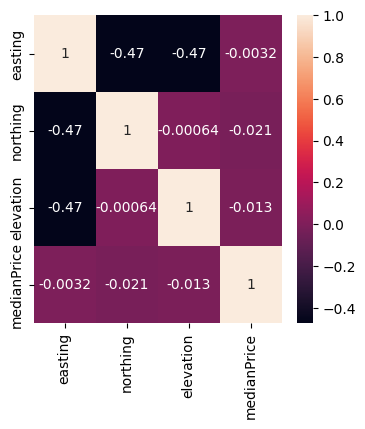

In [21]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(4,4))
corr = X_train[num_cols].corr()
sns.heatmap(data=corr, annot=True, ax=ax);

Apparently there are no highly correlated features but let's see if we can apply transformations to observer some 

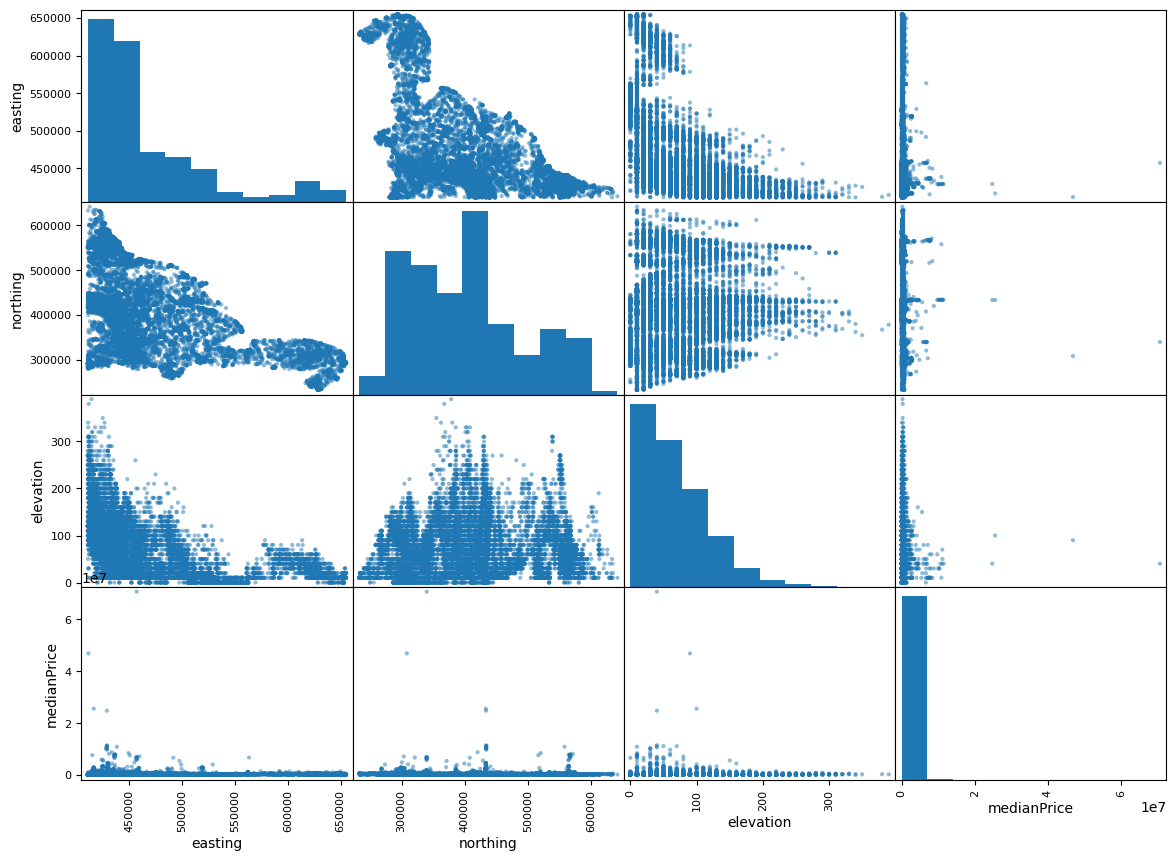

In [22]:
pd.plotting.scatter_matrix(X_train[num_cols], figsize=(14,10));

In [23]:
#X_train['medianPrice'] = np.log(X_train['medianPrice']+1)

In [24]:
#X_train['elevation'] = np.log(X_train['elevation']+1)

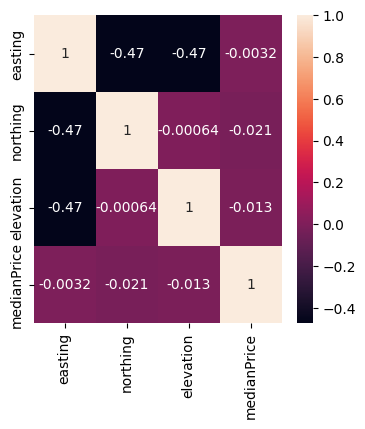

In [25]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
corr = X_train[num_cols].corr()
sns.heatmap(data=corr, annot=True, ax=ax);

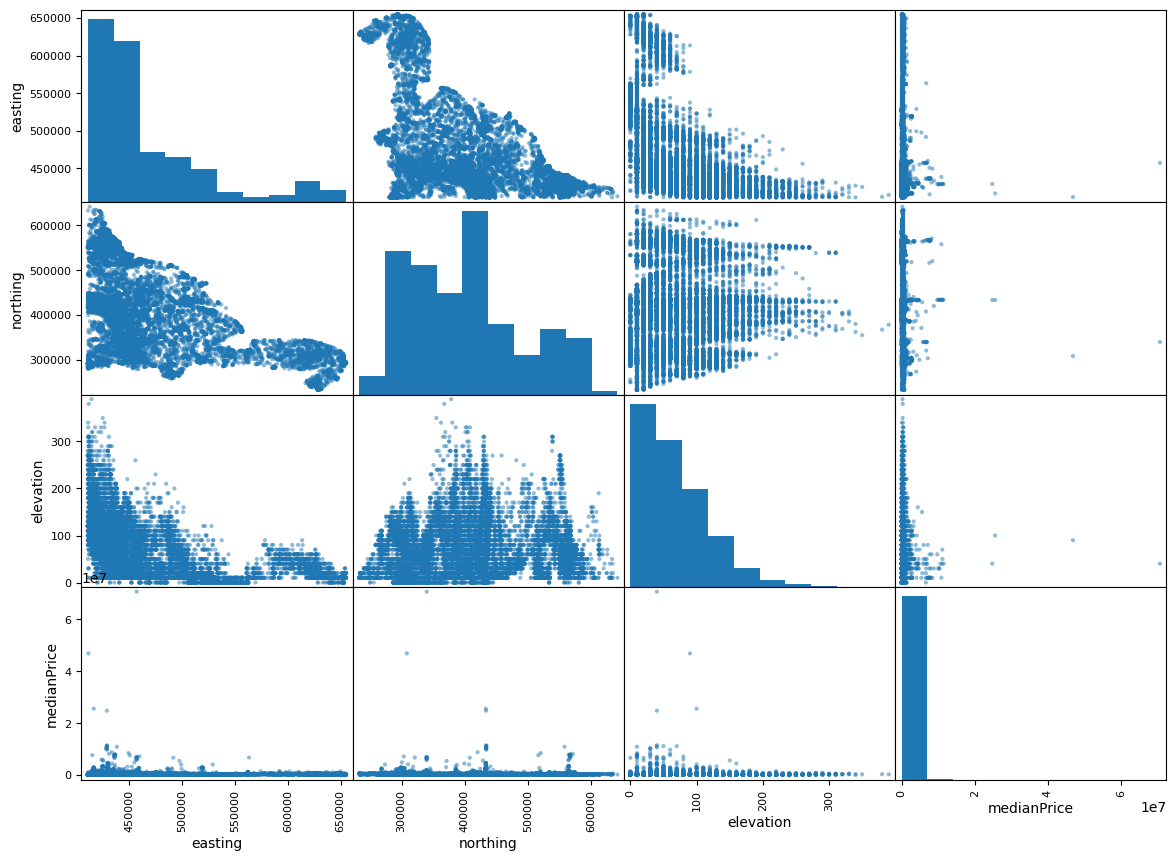

In [26]:
pd.plotting.scatter_matrix(X_train[num_cols], figsize=(14,10));

`MedianPrice` and `Elevation` seems to benefit from applying the `log`.

## 3. Categorical columns

In [27]:
for feature in cat_cols:
    print(X_train[feature].value_counts())

B10 9WD     1
DN11 0QE    1
YO31 7GF    1
YO3 7ZH     1
YO8 0GN     1
           ..
HG5 9BG     1
HG5 8DE     1
DH5 8EU     1
DE5 2GQ     1
NR32 1AJ    1
Name: postcode, Length: 24000, dtype: int64
Unsurveyed/Urban    15196
Stagnosols           2545
Cambisols            2301
Luvisols             1142
Gleysols             1010
Arenosols             861
Planosols             499
Leptosols             353
Podsols                50
Histosols              43
Name: soilType, dtype: int64
Leeds                      1456
Sheffield                   852
County Durham               838
Bradford                    732
Kirklees                    707
                           ... 
Calderdale                   90
Melton                       86
Rutland                      74
High Peak                     9
Staffordshire Moorlands       1
Name: localAuthority, Length: 82, dtype: int64
False    23074
True       926
Name: historicallyFlooded, dtype: int64


In [28]:
cat_cols = cat_cols.drop(['postcode', 'localAuthority'])

In [29]:
cat_cols

Index(['soilType', 'historicallyFlooded'], dtype='object')

## Pipelines

In [30]:
num_pipe = make_pipeline(SimpleImputer(), StandardScaler())
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore', sparse_output = False))


In [31]:
preproc_pipe = ColumnTransformer([('num_cols', num_pipe, num_cols),
                                 ('cat_cols', cat_pipe, cat_cols)])

In [32]:
preproc_pipe

ColumnTransformer(transformers=[('num_cols',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['easting', 'northing', 'elevation', 'medianPrice'], dtype='object')),
                                ('cat_cols',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['soilType', 'historicallyFlooded'], dtype='object'))])

## Dummy 

In [33]:
dummy_pipe = make_pipeline(preproc_pipe, DummyRegressor())

In [34]:
dummy_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation', 'medianPrice'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType', 'historicallyFlooded'], dtype='object'))])),
                ('dummyregressor', DummyRegressor())])

In [35]:
y_dummy_pred = dummy_pipe.predict(X_test)

In [36]:
y_dummy_pred

array([1.37870833, 1.37870833, 1.37870833, ..., 1.37870833, 1.37870833,
       1.37870833])

In [37]:
lr = make_pipeline(preproc_pipe, LinearRegression())

In [38]:
lr.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['easting', 'northing', 'elevation', 'medianPrice'], dtype='object')),
                                                 ('cat_cols',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['soilType', 'historicallyFlooded'], dtype='object'))])),
                ('linearregression', LinearRegression())])

In [39]:
y_train

20931    1
15507    1
4762     1
7161     1
7704     1
        ..
6178     1
17162    1
27617    1
19698    1
2538     1
Name: riskLabel, Length: 24000, dtype: int64

In [40]:
y_pred_lr = lr.predict(X_test)

In [41]:
y_pred_lr = y_pred_lr.astype(int)

In [42]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [43]:
y_pred_lr

array([2, 1, 1, ..., 0, 0, 1])

In [44]:
precision_score(y_test, y_pred_lr, average='micro')

0.5113333333333333

In [45]:
recall_score(y_test, y_pred_lr, average='micro')

0.5113333333333333

In [46]:
y.value_counts()

1     28124
6       691
8       484
7       182
4       163
5       115
9        65
3        61
10       58
2        57
Name: riskLabel, dtype: int64